## Text Classification Using FastAI’s ULMFiT

In [1]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2

# Optional: use this line if you want to remove Pandas'
# default concatenation of long text in columns
pd.set_option('display.max_colwidth', -1)

___
#### Explore data

In [2]:
df_text = pd.read_csv("./data/title_StackOverflow.txt", sep='\t', names=['text'], header=None)

In [3]:
df_text.head()

,text
0,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,How do you page a collection with LINQ?
2,Best Subversion clients for Windows Vista (64bit)
3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,Visual Studio Setup Project - Per User Registry Settings


In [4]:
df_label = pd.read_csv("./data/label_StackOverflow.txt", sep='\t', names=['label'], header=None)

In [5]:
df_label.head()

,label
0,18
1,18
2,3
3,3
4,7


In [6]:
df = pd.concat([df_label,df_text], axis = 1)
print('Length of dataset: '+str(len(df.index)))
df.head()

Length of dataset: 20000


,label,text
0,18,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,18,How do you page a collection with LINQ?
2,3,Best Subversion clients for Windows Vista (64bit)
3,3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,7,Visual Studio Setup Project - Per User Registry Settings


In [7]:
# do not do this for large data sets
mapping = {
  1: 'wordpress',
  2: 'oracle',
  3: 'svn',
  4: 'apache',
  5: 'excel',
  6: 'matlab',
  7: 'visual-studio',
  8: 'cocoa',
  9: 'osx',
  10: 'bash',
  11: 'spring',
  12: 'hibernate',
  13: 'scala',
  14: 'sharepoint',
  15: 'ajax',
  16: 'qt',
  17: 'drupal',
  18: 'linq',
  19: 'haskell',
  20: 'magento'
}
df['label'] = df['label'].map(mapping)
df.head()

,label,text
0,linq,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,linq,How do you page a collection with LINQ?
2,svn,Best Subversion clients for Windows Vista (64bit)
3,svn,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,visual-studio,Visual Studio Setup Project - Per User Registry Settings


In [8]:
# test - words to int and vice versa 
from collections import Counter
counts = Counter(df['label'])
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
# future references 

___
#### Create train & validation datasets and FastAI data bunch

In [9]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.3)
df_trn.shape, df_val.shape

((14000, 2), (6000, 2))

> TextLMDataBunch creates a data bunch for language modelling. In this, labels are completely ignored. Instead, data is processed so that the RNN can learn what word comes next given a starting word. 

> TextClasDataBunch sets up the data for classification. Labels play a key role here. We can also set the batch size for learning by changing the bs parameter.


In [10]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [11]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [12]:
data_clas.show_batch()

text,target
"xxbos xxmaj how xxmaj do i xxmaj loop xxmaj through xxmaj an xxmaj excel xxmaj spreadsheet xxmaj with xxup vba , xxmaj paste a xxmaj value xxmaj to a xxmaj website xxmaj form xxmaj then xxmaj extract xxmaj the xxmaj result xxmaj back ?",excel
"xxbos xxmaj in xxmaj oracle xxmaj xxunk ( xxup xxunk ) , is there a way to get the xxunk point of a polygon that is contained by the surface of the polygon ?",oracle
"xxbos xxmaj why would the browser cache assets ( images , js , etc . ) while getting but re - request everything after a xxup post + 302 redirect ?",apache
"xxbos xxmaj visual xxmaj studio xxmaj addin xxmaj development - xxmaj how to resolve the "" xxmaj the process can not access the file "" problem after xxunk visual studio ?",visual-studio
xxbos xxmaj making the xxmaj code check to see if the xxmaj text in a xxmaj text box matches any of the xxmaj strings in an nsarray .,cocoa


>The xx___ tags represent the aspects of language in a way that the computer can understand. The xxbos tag marks the beginning of a sentence. The xxmaj tag is used to imply that the first letter of the next word is capitalized.

___
#### Create and training the language model 

In [13]:
learn = language_model_learner(data_lm,AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


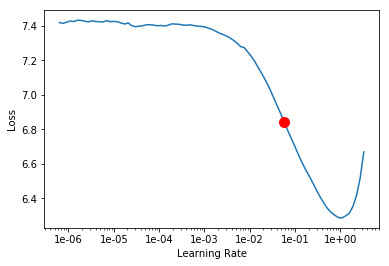

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [15]:
min_grad_lr

0.05754399373371566

In [16]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
1,5.158511,4.216070,0.302547,05:46
2,4.386769,4.085182,0.313157,09:10


In [17]:
learn.save_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02


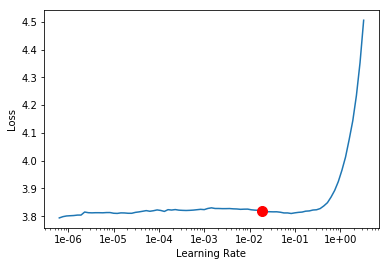

In [18]:
# another few epochs of training
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [19]:
min_grad_lr

0.019054607179632484

In [20]:
# unfreezing weights and training the rest of the NN
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
1,3.747772,3.968594,0.324396,13:20
2,3.624953,3.958264,0.326352,13:09


In [21]:
learn.save_encoder('ft_enc_1')

In [22]:
learn.predict("How do", n_words=10)

'How do i open a function to truncated extends when changing a'

____
#### Using the langauge model to train the classifier

In [23]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [24]:
learn.load_encoder('ft_enc_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


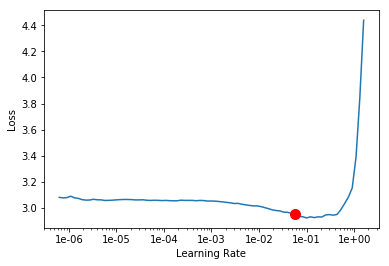

In [25]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [26]:
min_grad_lr

0.05754399373371566

In [27]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
1,2.420814,1.778637,0.492500,07:51
2,2.148424,1.474434,0.616667,07:55


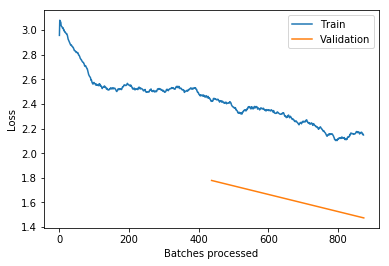

In [28]:
#track loss functions epoch 
learn.recorder.plot_losses()

In [29]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.794487,1.006230,0.725000,09:52
2,1.131097,0.770400,0.789833,09:44
3,1.036799,0.692126,0.807333,10:47
4,0.956133,0.683746,0.810833,11:19


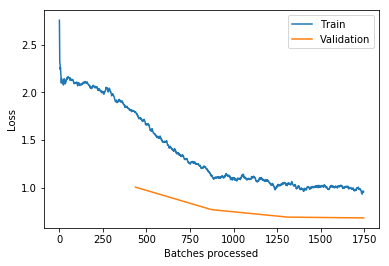

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.885699,0.665576,0.811667,22:22
2,0.815029,0.634369,0.823167,21:52
3,0.713388,0.611062,0.828333,22:10
4,0.751345,0.625562,0.832667,22:17


In [32]:
learn.save_encoder('ft_class')

____
### Analyzing Results 

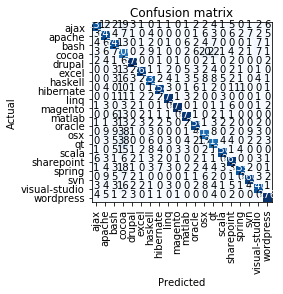

In [33]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()


In [34]:
interp.most_confused()

[('osx', 'cocoa', 38),
 ('qt', 'cocoa', 38),
 ('cocoa', 'qt', 22),
 ('cocoa', 'osx', 20),
 ('ajax', 'cocoa', 19),
 ('spring', 'cocoa', 18),
 ('haskell', 'cocoa', 16),
 ('visual-studio', 'cocoa', 16),
 ('scala', 'cocoa', 15),
 ('bash', 'cocoa', 13),
 ('excel', 'cocoa', 13),
 ('matlab', 'cocoa', 13),
 ('oracle', 'cocoa', 13),
 ('qt', 'osx', 13),
 ('ajax', 'apache', 12),
 ('hibernate', 'spring', 11),
 ('linq', 'cocoa', 11),
 ('hibernate', 'cocoa', 10),
 ('cocoa', 'haskell', 9),
 ('osx', 'apache', 9),
 ('osx', 'bash', 9),
 ('osx', 'svn', 9),
 ('svn', 'apache', 9),
 ('haskell', 'osx', 8),
 ('haskell', 'qt', 8),
 ('osx', 'qt', 8),
 ('scala', 'haskell', 8),
 ('visual-studio', 'osx', 8),
 ('apache', 'cocoa', 7),
 ('apache', 'svn', 7),
 ('bash', 'qt', 7),
 ('bash', 'visual-studio', 7),
 ('cocoa', 'bash', 7),
 ('cocoa', 'visual-studio', 7),
 ('spring', 'hibernate', 7),
 ('svn', 'cocoa', 7),
 ('ajax', 'wordpress', 6),
 ('apache', 'osx', 6),
 ('apache', 'sharepoint', 6),
 ('bash', 'apache', 6),
 (

____
### Predict

In [49]:
from collections import Counter 

In [52]:
counts = Counter(learn.data.classes)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 0)}

In [53]:
vocab_to_int

{'ajax': 0,
 'apache': 1,
 'bash': 2,
 'cocoa': 3,
 'drupal': 4,
 'excel': 5,
 'haskell': 6,
 'hibernate': 7,
 'linq': 8,
 'magento': 9,
 'matlab': 10,
 'oracle': 11,
 'osx': 12,
 'qt': 13,
 'scala': 14,
 'sharepoint': 15,
 'spring': 16,
 'svn': 17,
 'visual-studio': 18,
 'wordpress': 19}

In [62]:
# learn eval ?? 
learn.predict("NSOutline View Creates memory leaks in Swift")

(<fastai.core.Category at 0x7f61e1dd0240>,
 tensor(3),
 tensor([0.0433, 0.0295, 0.0075, 0.2578, 0.0296, 0.0248, 0.0586, 0.0369, 0.0148,
         0.0201, 0.0206, 0.0194, 0.0757, 0.1041, 0.0424, 0.0982, 0.0647, 0.0096,
         0.0277, 0.0146]))

___
### Export

In [57]:
learn.export()